In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml

%matplotlib inline

# MNIST

Получаем набор данных MNIST с помощью sklearn функции **fetch_openml**, возвращающая объект DataFrame по умолчанию. Поэтому, необходимо установить флаг **as_frame** в False.

In [3]:
X, y = fetch_openml('mnist_784', as_frame=False, return_X_y=True)

In [4]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

Состав MNIST - первые 60 тысяч **train** данных и остальные 10 тысяч **test** данных. При этом длина каждой строки - 784 пикселя, т.е. 28х28.

In [10]:
X.shape

((70000, 784), array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

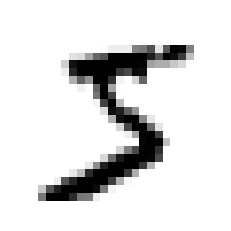

In [9]:
plt.imshow(X[0].reshape(28, 28), cmap=mpl.cm.binary)
plt.axis(False)
plt.show()

Так как **y** имеет строковый формат, преобразуем их в int.

In [12]:
y = y.astype(int)
y

array([5, 0, 4, ..., 4, 5, 6])

In [13]:
def draw_image(images, images_per_row=5):
    for index, image in enumerate(images):
        image = image.reshape(28, 28)
        n_rows = (len(images)-1) // images_per_row + 1
        plt.subplot(n_rows, images_per_row, index+1)
        plt.imshow(image, cmap=mpl.cm.binary)
        plt.axis(False)

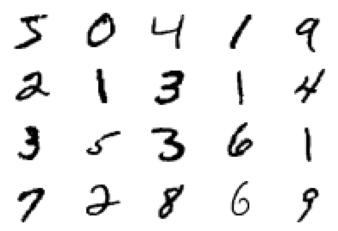

In [15]:
draw_image(X[:20])